In [91]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import grangercausalitytests
from pyinform import transferentropy
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

In [52]:
# Load the dataset
file_path = "data/Derivation_dataset.csv"
df = pd.read_csv(file_path)


# Drop rows with any NaN values
df = df.dropna()


# Ensure column names do not have leading/trailing spaces
df.columns = df.columns.str.strip()


In [53]:
# Define the target variable
target = 'Outcome_Occlusion_MI'

# Drop non-numeric columns (if any)
df = df.select_dtypes(include=[np.number])

# Ensure the target variable exists
if target not in df.columns:
    raise ValueError(f"Target variable '{target}' not found in dataset.")

# Maximum lag to test
max_lag = 3

### Linear and Non-Linear Granger Causality Test

#### using pyinform

In [54]:

# Store p-values for linear Granger causality
linear_causality_scores = {}
nonlinear_causality_scores = {}

for col in df.columns:
    if col == target:
        continue  # Skip the target variable itself
    
    try:
        # --- Linear Granger Causality ---
        test_result = grangercausalitytests(df[[target, col]], max_lag, verbose=False)
        
        # Extract the minimum p-value across all lags
        min_p_value = min([test_result[lag][0]['ssr_ftest'][1] for lag in range(1, max_lag + 1)])
        linear_causality_scores[col] = min_p_value

        # --- Nonlinear Granger Causality (Transfer Entropy) ---
        X = df[col].tolist()
        Y = df[target].tolist()
        te_value = transferentropy(X, Y, k=1)  # k=1 means using a 1-lag for prediction

        nonlinear_causality_scores[col] = te_value

    except Exception as e:
        print(f"Skipping {col} due to error: {e}")

Skipping Age due to error: 'module' object is not callable
Skipping HR due to error: 'module' object is not callable
Skipping PR due to error: 'module' object is not callable
Skipping QRSd due to error: 'module' object is not callable
Skipping mfpQRSaxis due to error: 'module' object is not callable
Skipping fpTaxis due to error: 'module' object is not callable
Skipping txzQRSaxis due to error: 'module' object is not callable
Skipping QRSTangle due to error: 'module' object is not callable
Skipping mQRSTangle due to error: 'module' object is not callable
Skipping TCRTangle due to error: 'module' object is not callable
Skipping TCRT due to error: 'module' object is not callable
Skipping TampInfl1 due to error: 'module' object is not callable
Skipping Tamp due to error: 'module' object is not callable
Skipping TrelAmp due to error: 'module' object is not callable
Skipping fpTinfl1Axis due to error: 'module' object is not callable
Skipping fpTinfl1Mag due to error: 'module' object is not 

In [55]:
# Sort by linear p-value (lower = stronger causality)
top_25_linear = sorted(linear_causality_scores, key=linear_causality_scores.get)[:25]

# Sort by nonlinear transfer entropy (higher = stronger causality)
top_25_nonlinear = sorted(nonlinear_causality_scores, key=nonlinear_causality_scores.get, reverse=True)[:25]

# Print results
print("\nTop 25 Variables Granger-causing (Linear) Outcome_Occlusion_MI:")
for var in top_25_linear:
    print(f"{var}: p-value = {linear_causality_scores[var]}")

print("\nTop 25 Variables Granger-causing (Nonlinear) Outcome_Occlusion_MI:")
for var in top_25_nonlinear:
    print(f"{var}: Transfer Entropy = {nonlinear_causality_scores[var]}")


Top 25 Variables Granger-causing (Linear) Outcome_Occlusion_MI:
st80_I: p-value = 0.003243892422701688
vat_V2: p-value = 0.011738678916687794
vat_V4: p-value = 0.011886955932412674
st80_V2: p-value = 0.011955465381957363
qdur_aVF: p-value = 0.015855044036887322
st80_aVL: p-value = 0.0182915949292697
tamp_V2: p-value = 0.023743591401503616
PR: p-value = 0.023907708348106033
pcaTamp: p-value = 0.029626672613689987
Age: p-value = 0.037968119274323364
TpTe: p-value = 0.048767443478420304
PCA3: p-value = 0.05468054007782664
pctTNDPV: p-value = 0.059676987407964656
tamp_aVL: p-value = 0.060781137540589385
latConcaveAmp: p-value = 0.0664630094835095
antConcaveAmp: p-value = 0.08559574746978615
PCA1: p-value = 0.09269780287389039
QRSd: p-value = 0.09488505876701006
tamp_I: p-value = 0.10163451400883482
rmsMin: p-value = 0.10512969787079116
TrelAmp: p-value = 0.11902137501850626
MIsz: p-value = 0.11971998617152084
pctJNDPV: p-value = 0.13138163933290412
tamp_III: p-value = 0.13922607390244304


#### using sklearn.feature_selection

In [56]:
# Store p-values for linear Granger causality
linear_causality_scores = {}
nonlinear_causality_scores = {}

for col in df.columns:
    if col == target:
        continue  # Skip the target variable itself
    
    try:
        # --- Linear Granger Causality ---
        test_result = grangercausalitytests(df[[target, col]], max_lag, verbose=False)
        
        # Extract the minimum p-value across all lags
        min_p_value = min([test_result[lag][0]['ssr_ftest'][1] for lag in range(1, max_lag + 1)])
        linear_causality_scores[col] = min_p_value

        # --- Nonlinear Granger Causality (Mutual Information Approximation) ---
        X = df[col].values.reshape(-1, 1)  # Predictor
        Y = df[target].values  # Target
        mi_score = mutual_info_regression(X, Y, discrete_features=False)[0]  # Mutual Information

        nonlinear_causality_scores[col] = mi_score

    except Exception as e:
        print(f"Skipping {col} due to error: {e}")

In [57]:
# Sort by linear p-value (lower = stronger causality)
top_25_linear = sorted(linear_causality_scores, key=linear_causality_scores.get)[:25]

# Sort by nonlinear transfer entropy (higher = stronger causality)
top_25_nonlinear = sorted(nonlinear_causality_scores, key=nonlinear_causality_scores.get, reverse=True)[:25]

# Print results
print("\nTop 25 Variables Granger-causing (Linear) Outcome_Occlusion_MI:")
for var in top_25_linear:
    print(f"{var}: p-value = {linear_causality_scores[var]}")

print("\nTop 25 Variables Granger-causing (Nonlinear) Outcome_Occlusion_MI:")
for var in top_25_nonlinear:
    print(f"{var}: Transfer Entropy = {nonlinear_causality_scores[var]}")


Top 25 Variables Granger-causing (Linear) Outcome_Occlusion_MI:
st80_I: p-value = 0.003243892422701688
vat_V2: p-value = 0.011738678916687794
vat_V4: p-value = 0.011886955932412674
st80_V2: p-value = 0.011955465381957363
qdur_aVF: p-value = 0.015855044036887322
st80_aVL: p-value = 0.0182915949292697
tamp_V2: p-value = 0.023743591401503616
PR: p-value = 0.023907708348106033
pcaTamp: p-value = 0.029626672613689987
Age: p-value = 0.037968119274323364
TpTe: p-value = 0.048767443478420304
PCA3: p-value = 0.05468054007782664
pctTNDPV: p-value = 0.059676987407964656
tamp_aVL: p-value = 0.060781137540589385
latConcaveAmp: p-value = 0.0664630094835095
antConcaveAmp: p-value = 0.08559574746978615
PCA1: p-value = 0.09269780287389039
QRSd: p-value = 0.09488505876701006
tamp_I: p-value = 0.10163451400883482
rmsMin: p-value = 0.10512969787079116
TrelAmp: p-value = 0.11902137501850626
MIsz: p-value = 0.11971998617152084
pctJNDPV: p-value = 0.13138163933290412
tamp_III: p-value = 0.13922607390244304


In [58]:
feature_list = [
    "st80_III", "st80_aVL", "tamp_aVL", "STT_PCAratio", "st80_V2", "TpTe",
    "st80_aVF", "tamp_III", "st80_I", "pcaTamp", "st80_V6", "fpTaxis",
    "st80_V1", "fpTinfl1Axis", "PCA2", "TampInfl1", "Age", "tamp_aVF",
    "antConcaveAmp", "TCRT", "T_PCAratio", "st80_V4", "HR", "tamp_V4", "st80_V3"
]


In [59]:
# Elements in words_list but NOT in top_25_linear
not_in_linear = [var for var in feature_list if var not in top_25_linear]

# Elements in top_25_linear but NOT in words_list
not_in_feature_list = [var for var in top_25_linear if var not in feature_list]

# Print results
print("Elements in feature_list but NOT in top_25_nonlinear:", not_in_linear)
print("Elements in top_25_nonlinear but NOT in feature_list:", not_in_feature_list)

Elements in feature_list but NOT in top_25_nonlinear: ['st80_III', 'STT_PCAratio', 'st80_aVF', 'st80_V6', 'fpTaxis', 'st80_V1', 'fpTinfl1Axis', 'PCA2', 'TampInfl1', 'tamp_aVF', 'TCRT', 'T_PCAratio', 'st80_V4', 'HR', 'tamp_V4', 'st80_V3']
Elements in top_25_nonlinear but NOT in feature_list: ['vat_V2', 'vat_V4', 'qdur_aVF', 'tamp_V2', 'PR', 'PCA3', 'pctTNDPV', 'latConcaveAmp', 'PCA1', 'QRSd', 'tamp_I', 'rmsMin', 'TrelAmp', 'MIsz', 'pctJNDPV', 'QRS_PCAratio']


In [60]:
# Elements in words_list but NOT in top_25_nonlinear
not_in_nonlinear = [var for var in feature_list if var not in top_25_nonlinear]

# Elements in top_25_nonlinear but NOT in words_list
not_in_feature_list = [var for var in top_25_nonlinear if var not in feature_list]

# Print results
print("Elements in feature_list but NOT in top_25_nonlinear:", not_in_nonlinear)
print("Elements in top_25_nonlinear but NOT in feature_list:", not_in_feature_list)

Elements in feature_list but NOT in top_25_nonlinear: ['STT_PCAratio', 'fpTaxis', 'PCA2', 'TampInfl1', 'Age', 'antConcaveAmp', 'TCRT', 'T_PCAratio', 'st80_V4', 'tamp_V4']
Elements in top_25_nonlinear but NOT in feature_list: ['tamp_V2', 'tamp_I', 'tamp_V6', 'QRSd', 'tamp_V5', 'fpTinfl1Mag', 'mfpQRSaxis', 'Tamp', 'TrelAmp', 'QRSTangle']


## Prediction

In [61]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

In [62]:
# Extract features and target
X = df[top_25_nonlinear]
y = df[target]

In [63]:
y.shape

(3443,)

In [64]:
# Split into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train a Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predict on test set
y_pred = clf.predict(X_test)

In [65]:
# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred))

# Show feature importance
feature_importance = pd.Series(clf.feature_importances_, index=top_25_nonlinear).sort_values(ascending=False)
print("Top Features by Importance:\n", feature_importance)

Accuracy: 0.9536
Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98       652
           1       0.78      0.19      0.30        37

    accuracy                           0.95       689
   macro avg       0.87      0.59      0.64       689
weighted avg       0.95      0.95      0.94       689

Top Features by Importance:
 st80_aVL        0.076113
st80_III        0.057393
st80_V2         0.055844
mfpQRSaxis      0.054340
QRSTangle       0.053395
st80_V3         0.046472
st80_I          0.045429
st80_aVF        0.042405
pcaTamp         0.040192
tamp_aVL        0.039879
tamp_III        0.039769
QRSd            0.037689
st80_V6         0.036687
tamp_V2         0.036207
tamp_aVF        0.035726
TpTe            0.035164
tamp_V5         0.034221
HR              0.033354
tamp_V6         0.031691
Tamp            0.029641
fpTinfl1Axis    0.029624
tamp_I          0.029602
st80_V1         0.027805
TrelAmp         0.025748
fpT

In [66]:
# Load the external validation dataset
data_path = "data\\External_validation_dataset.csv"
external_data = pd.read_csv(data_path)

In [67]:
# Drop rows with any NaN values
external_data = external_data.dropna()

# Ensure column names do not have leading/trailing spaces
external_data.columns = external_data.columns.str.strip()


In [68]:
# Ensure the dataset has the same features as the training set
X_external = external_data[X_train.columns]  # Select only relevant columns

y_external_test = external_data["Outcome_Occlusion_MI"]
# Predict using the trained model
y_external_pred = clf.predict(X_external)

# Save predictions
external_data["Predictions"] = y_external_pred
# external_data.to_csv("external_predictions.csv", index=False)

print("Predictions saved to external_predictions.csv")

Predictions saved to external_predictions.csv


In [69]:
print("Classification Report:\n", classification_report(y_external_test, y_external_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.99      0.97      2453
           1       0.71      0.30      0.42       186

    accuracy                           0.94      2639
   macro avg       0.83      0.65      0.70      2639
weighted avg       0.93      0.94      0.93      2639



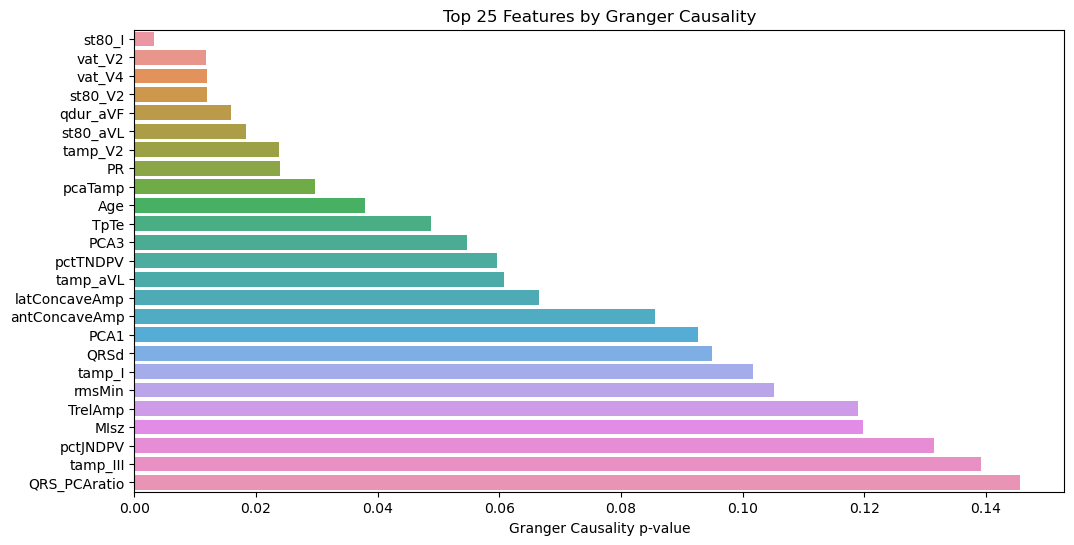

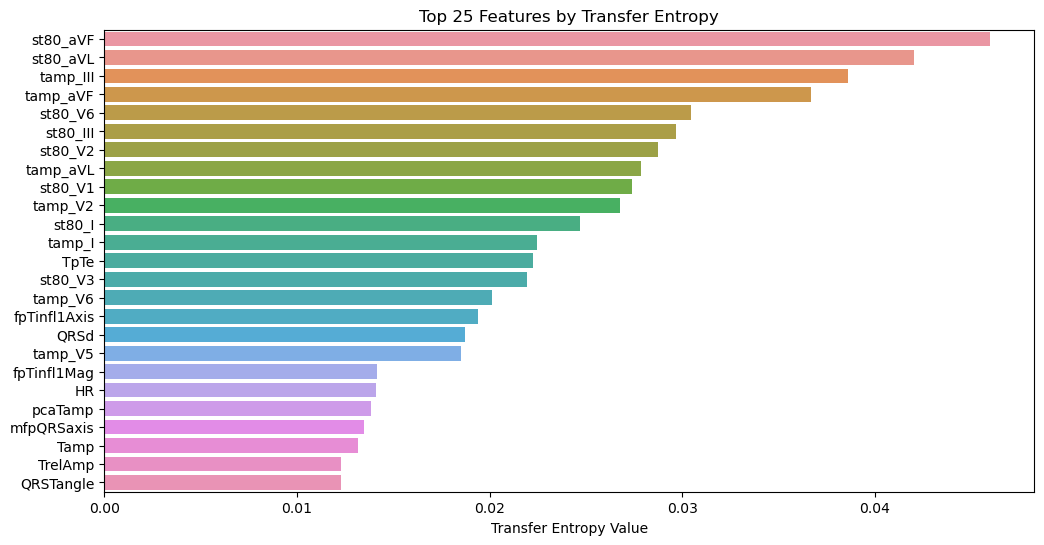

In [70]:
# Bar plot for Granger Causality
plt.figure(figsize=(12, 6))
sns.barplot(x=[linear_causality_scores[var] for var in top_25_linear], y=top_25_linear)
plt.xlabel("Granger Causality p-value")
plt.title("Top 25 Features by Granger Causality")
plt.show()

# Bar plot for Transfer Entropy
plt.figure(figsize=(12, 6))
sns.barplot(x=[nonlinear_causality_scores[var] for var in top_25_nonlinear], y=top_25_nonlinear)
plt.xlabel("Transfer Entropy Value")
plt.title("Top 25 Features by Transfer Entropy")
plt.show()


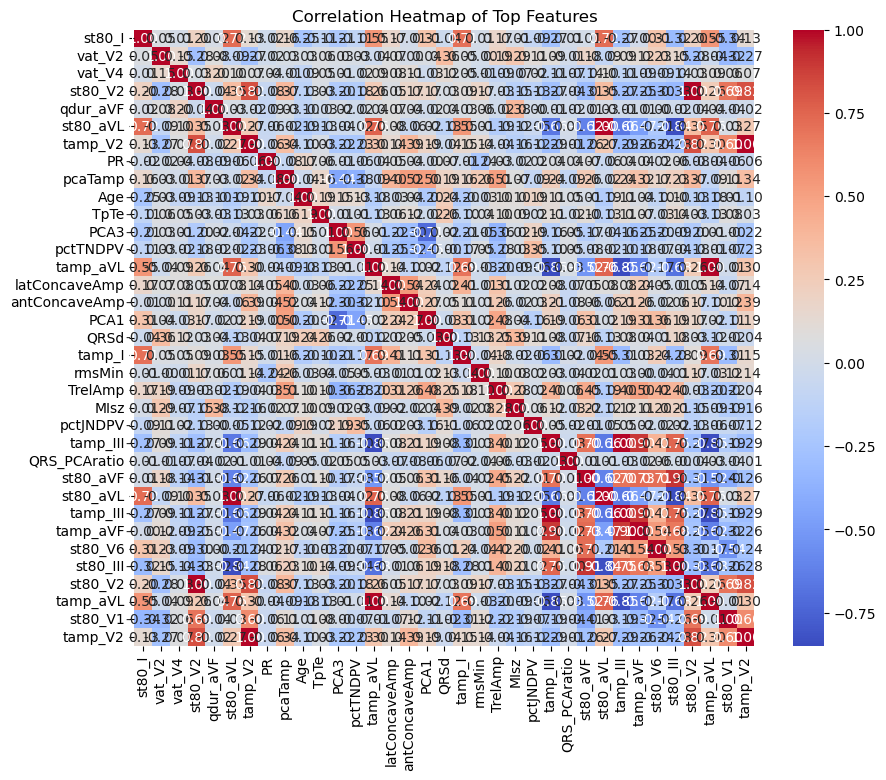

In [71]:
# Heatmap of top 10 features correlation
top_features = top_25_linear + top_25_nonlinear[:10]
corr_matrix = df[top_features].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Top Features")
plt.show()

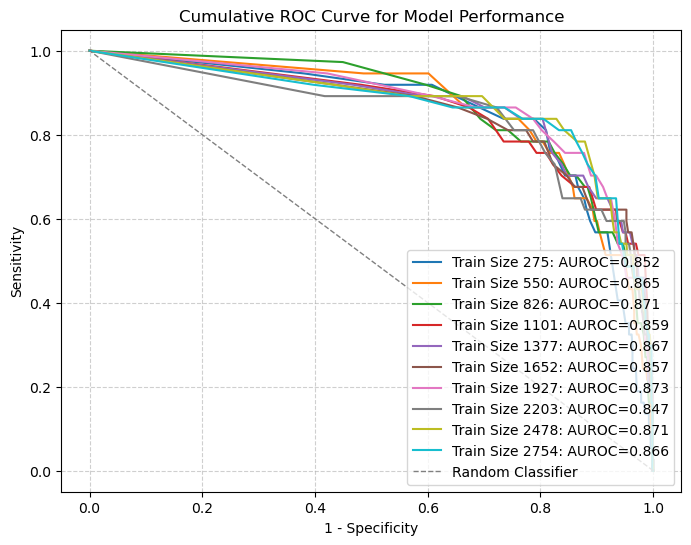

In [89]:
# Define training sizes (10% to 100% of training data)
train_sizes = np.linspace(0.1, 1.0, 10)

# Store cumulative ROC curves
plt.figure(figsize=(8, 6))

for train_size in train_sizes:
    # Subset the training data
    subset_size = int(train_size * len(X_train))
    X_train_subset = X_train[:subset_size]
    y_train_subset = y_train[:subset_size]

    # Train a Random Forest model
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train_subset, y_train_subset)

    # Predict probabilities on test set
    y_scores = clf.predict_proba(X_test)[:, 1]

    # Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)

    # Corrected Plot: 1 - Specificity (False Positive Rate) vs. Sensitivity (True Positive Rate)
    plt.plot(1 - fpr, tpr, lw=1.5, label=f"Train Size {subset_size}: AUROC={roc_auc:.3f}")

# Reference random classifier line
plt.plot([1, 0], [0, 1], color='gray', linestyle='--', lw=1, label="Random Classifier")

# Labels and title
plt.xlabel("1 - Specificity")  # Corrected X-axis
plt.ylabel("Sensitivity")  # Corrected Y-axis
plt.title("Cumulative ROC Curve for Model Performance")
plt.legend(loc="lower right")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

Fitting 5 folds for each of 162 candidates, totalling 810 fits
Best Parameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}


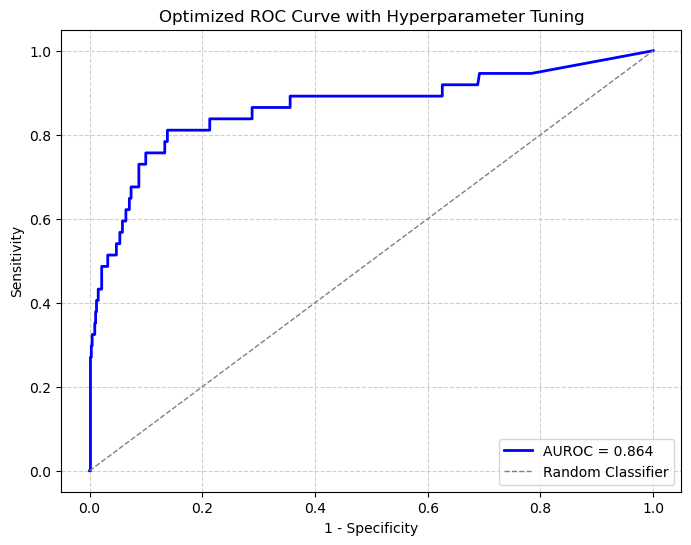

In [92]:
# Define hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees in the forest
    'max_depth': [None, 10, 20],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum samples required to split a node
    'min_samples_leaf': [1, 2, 4],  # Minimum samples required at a leaf node
    'max_features': ['sqrt', 'log2']  # Number of features to consider at each split
}

# Perform Grid Search with 5-fold Cross Validation
clf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Get the best model
best_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

# Predict probabilities on test set
y_scores = best_model.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUROC = {roc_auc:.3f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1, label="Random Classifier")
plt.xlabel("1 - Specificity")
plt.ylabel("Sensitivity")
plt.title("Optimized ROC Curve with Hyperparameter Tuning")
plt.legend(loc="lower right")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()